# 3 Proven Ways to Make Time Series Data Stationary in Python
## Algorithms can't handle non-stationary. They need something static
![](images/unsplash.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://unsplash.com/@jonathanpielmayer?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText'>Jonathan Pielmayer</a>
        on 
        <a href='https://unsplash.com/s/photos/still?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText'>Unsplash.</a> All images are by author unless specified otherwise.
    </strong>
</figcaption>

## Setup

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
plt.style.use("ggplot")

## Introduction

Unlike ordinary machine learning problems, time series forecasting requires *extra* preprocessing steps. 

On top of the normality assumptions, the majority of ML algorithms expect a *static relationship* between the input features and the output. 

A static relationship requires inputs and outputs that have constant parameters such as mean, median and variance. In other words, algorithms perform best when the inputs and outputs are *stationary*. 

This is not the case in time series forecasting. Distributions that change over time can have unique properties such as seasonality and trend. These, in turn, cause mean and variance of the series to fluctuate making it hard to model their behavior.

So, making a distribution stationary is a strict requirement in time series forecasting. In this article, we will explore several techniques to detect non-stationary distributions and convert them into stationary data.

## Examples of non-stationary series

Take a look at these plots and try to guess which of the lines represent a stationary series:

![](https://otexts.com/fpp2/fpp_files/figure-html/stationary-1.png)
<figcaption style="text-align: center;">
    <strong>
        Image by <a href='https://otexts.com/fpp2/'>otexts.com</a> [1]
    </strong>
</figcaption>

Since stationary series have constant variance, we can rule out **a, c, e, f** and **i**. These plots show a clear upward or downward trend or changing levels like in **f**. 

**d** and **h** show seasonal patterns, we can rule them out too. But how about **g** - the pattern does look it is seasonal. 

**g** is the plot of the population growth of [lynxes](https://en.wikipedia.org/wiki/Lynx). When food becomes scarce, they stop breeding causing the population numbers to plummet. When the food sources replenish, they start reproducing again making the population grow. 

This cyclic behavior is not the same as seasonality. When seasonality exists, you know exactly what will happen after a certain period of time. In contrast, the cyclic behavior of lynx population growth is unpredictable. You can't guess the timing of the food cycles making this series stationary.

So, the only stationary series are **b** and **g**. 

Tricky distributions like **d, f** and **h** can make you question whether identifying non-stationary data visually is the best option. As you observed, it is pretty easy to confuse seasonality to random cycles or trends to white noise. 

For this reason, the next section will be about statistical methods of detecting non-stationary time series.

## Detecting non-stationarity statistically

In statistics world, there are a number of tests under the label of *[unit root tests](https://en.wikipedia.org/wiki/Unit_root_test#:~:text=In%20statistics%2C%20a%20unit%20root,depending%20on%20the%20test%20used.)*. Augmented Dickey-Fuller test maybe one of the most popular one and we have already seen how to use to detect random walks in [my last post](https://towardsdatascience.com/how-to-detect-random-walk-and-white-noise-in-time-series-forecasting-bdb5bbd4ef81?source=your_stories_page-------------------------------------).

Here, we will see how to use it to check if a series is stationary or not. 

Simply put, here are the null and alternative hypotheses of this test:
- The null hypothesis: the distribution is non-stationary, time-dependent (it has a unit root)
- The alternative hypothesis: the distribution is stationary, not time-dependent (can't be represented by a unit root).

The result of the test is determined by the p-value. If it smaller than a critical threshold of 0.05 or 0.01, we reject the null hypothesis and conclude that the series is stationary. Otherwise, we fail to reject the null and conclude the series is non-stationary.

The full test is conveniently implemented as `adfuller` function under `statsmodels`. First, let's use it on a distribution we know is stationary and get familiarized with its output:

In [4]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

diamonds = sns.load_dataset("diamonds")

test_results = adfuller(diamonds["price"])

print(f"ADF test statistic: {test_results[0]}")
print(f"p-value: {test_results[1]}")
print("Critical thresholds:")
for key, value in test_results[4].items():
    print(f"\t{key}: {value}")

ADF test statistic: -8.1149306683156
p-value: 1.1980457313376738e-12
Critical thresholds:
	1%: -3.430471308341908
	5%: -2.8615936158814588
	10%: -2.566798537945544


We look at the p-value, which is almost 0. This means we can easily reject the null and consider the distribution as stationary.

Now, let's load the TPS July Playground dataset from Kaggle and check if the target carbon monoxide is stationary or not:

In [16]:
tps_july = pd.read_csv(
    "data/tps_july_train.csv", parse_dates=["date_time"], index_col="date_time"
)

test_results = adfuller(tps_july["target_carbon_monoxide"])

test_results[1]

7.26341357249666e-15

Surprisingly, carbon monoxide is found to be stationary. This might be due to the fact that the data is recorded over a short period of time and this removed the temporal component. In fact, all other variables in the data are completely stationary.

Now, let's load some stock data and check them for stationary:

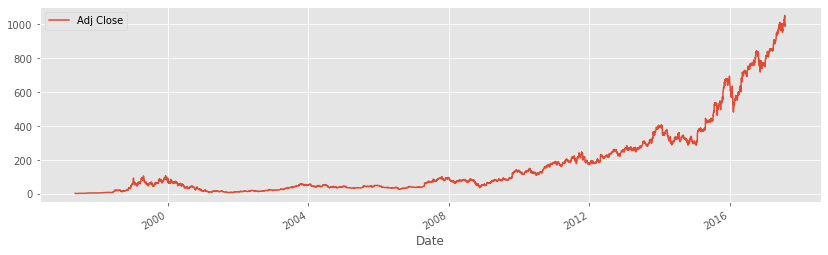

In [18]:
ts1 = pd.read_csv("data/AMZN.csv", parse_dates=["Date"], index_col="Date")

ts1.plot(figsize=(14, 4));

As you can see, the series shows a clear upward trend. Let's perform the Dickey-Fuller test:

In [19]:
ts1_results = adfuller(ts1["Adj Close"])

ts1_results[1]

1.0

We get a perfect p-value of 1 - this is a 100% non-stationary time series data. Let's perform a last test on another distribution and we will move on to different techniques you can deal with non-stationary data:

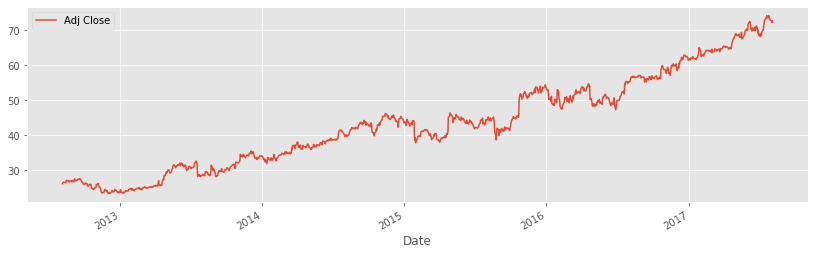

In [21]:
ts2 = pd.read_csv("data/MSFT.csv", parse_dates=["Date"], index_col="Date")

ts2.plot(figsize=(14, 4));

In [22]:
ts2_results = adfuller(ts2["Adj Close"])

ts2_results[1]

0.9711208852369689

p-value is close to 1. No interpretation is necessary.